In [1]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import time
import copy

In [2]:
#%%
import matplotlib.pyplot as plt
import matplotlib as mpb

In [3]:
transformers = {'train' : transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
'test' : transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
'val' : transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])}
modes = ['train', 'test', 'val']

In [4]:
datasets = {mode: ImageFolder('../'+mode, transformers[mode]) for mode in modes}
dataloaders = {mode: DataLoader(datasets[mode], batch_size=32, shuffle=True) for mode in modes}
datasets_sizes = {mode: len(datasets[mode]) for mode in modes}

In [5]:
print(datasets['train'].class_to_idx.keys())
print(datasets_sizes)

dict_keys(['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS'])
{'train': 5216, 'test': 624, 'val': 16}


In [6]:
model = torchvision.models.resnet18(pretrained=True)
# for params in model.parameters():
#     params.required_grad = False
    
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256,3))
model = model.cuda()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.001)

In [8]:
best_model = None
best_loss = 0.
best_test_loss = 0.
best_test_acc = 0.
best_pred_labels = []
true_labels = []
pred_labels = []
test_acc = 0.
test_loss = 0.
batch_size = 32

In [11]:
def fit(model, dataloader, criterion, optimizer, mode='train'):
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []
    
    for batch_idx, (data, labels) in enumerate(dataloader):
        data, labels = data.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(mode == 'train'):
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        
        true_labels.append(labels.detach().cpu())
        pred_labels.append(preds.detach().cpu())
        
        if mode == 'train':
            loss.backward()
            optimizer.step()
        
        print(f'\r{mode} batch [{batch_idx}/{len(dataloader)}]: loss {loss.item()}', end='', flush=True)
        epoch_loss += loss.item()
        epoch_acc += torch.sum(preds == labels.data)
        batch_num += 1
        samples_num += len(labels)
    print()
    return epoch_loss / batch_num, epoch_acc.double() / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [12]:
train_losses = []
val_losses = []
test_losses = []
train_accs = []
val_accs = []
test_accs = []

for epoch in range(10):
    print('='*15, f'Epoch: {epoch}')
    
    train_loss, train_acc, _, _ = fit(model, dataloaders['train'], criterion, optimizer)
    val_loss, val_acc, _, _ = fit(model, dataloaders['val'], criterion, optimizer, mode='val')
    test_loss, test_acc, true_labels, pred_labels = fit(model, dataloaders['test'], criterion, optimizer, mode='test')
    
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
    print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
    print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')
    print()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    
    if best_model is None or val_loss < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_test_loss = test_loss
        best_test_acc = test_acc 
        best_pred_labels = pred_labels

torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet18-mooney-chest-x-ray-best.pt')

=============== Epoch: 0
train batch [162/163]: loss 0.6160500645637512
val batch [0/1]: loss 1.0450212955474854
test batch [19/20]: loss 0.9742656350135803
Train loss: 0.8820007055815012, Train accuracy: 0.6209739263803681
Val loss: 1.0450212955474854, Val accuracy: 0.6875
Test loss: 1.0043601751327516, Test accuracy: 0.5192307692307692

=============== Epoch: 1
train batch [162/163]: loss 0.58575689792633065
val batch [0/1]: loss 1.1437740325927734
test batch [19/20]: loss 0.7370138168334961
Train loss: 0.6973791332698307, Train accuracy: 0.6731211656441718
Val loss: 1.1437740325927734, Val accuracy: 0.625
Test loss: 0.9043369084596634, Test accuracy: 0.5817307692307692

=============== Epoch: 2
train batch [162/163]: loss 0.68100500106811524
val batch [0/1]: loss 0.6750633120536804
test batch [19/20]: loss 0.9563654065132141
Train loss: 0.6866382376913645, Train accuracy: 0.6744631901840491
Val loss: 0.6750633120536804, Val accuracy: 0.8125
Test loss: 0.8891143411397934, Test accura

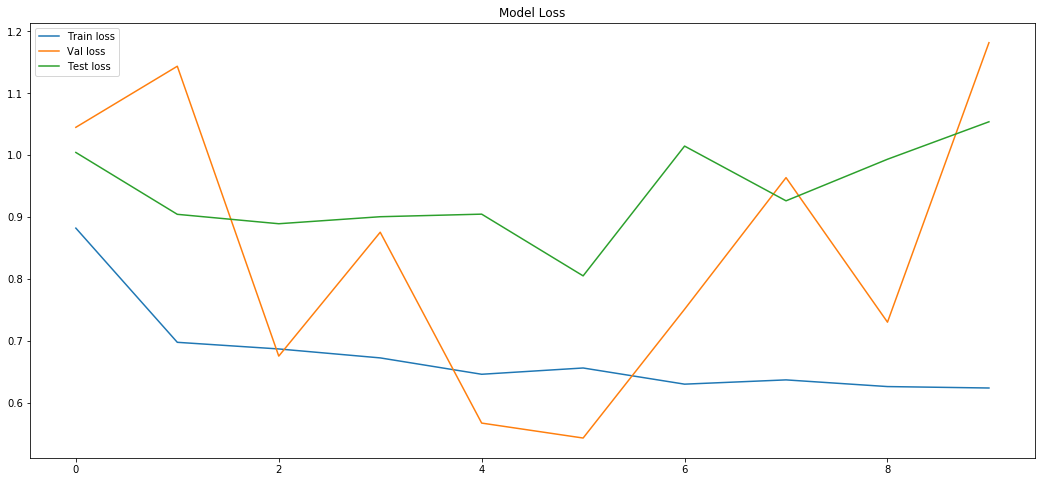

In [13]:
plt.figure(figsize=(18, 8))
plt.title('Model Loss')
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

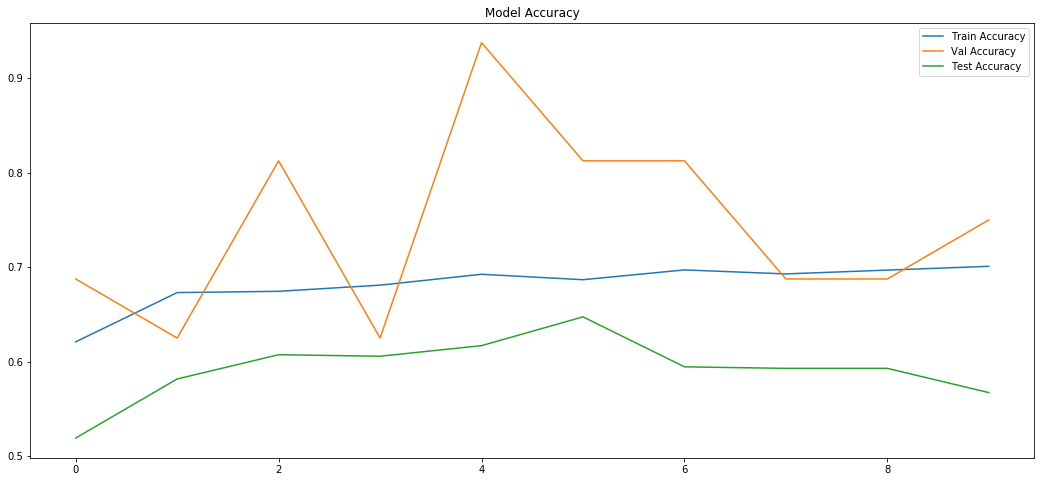

In [14]:
plt.figure(figsize=(18, 8))
plt.title('Model Accuracy')
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.legend()
plt.show()

{'NORMAL': 0, 'PNEUMONIA_BACTERIA': 1, 'PNEUMONIA_VIRUS': 2}


Text(0.5, 0, 'Predicted label')

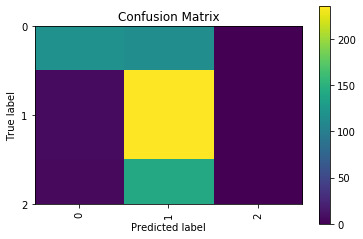

In [23]:
from sklearn.metrics import confusion_matrix

print(datasets['test'].class_to_idx)
matrix = confusion_matrix(true_labels, pred_labels)
plt.imshow(matrix, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
labels = range(3)
plt.xticks(labels, labels, rotation=90)
plt.yticks(labels, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')